## Advanced NN

### Import Module

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings(action='ignore')

### Data Label

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

### Read Data

In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
submission = pd.read_csv('submission.csv')

In [3]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [4]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,67,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,2,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,93,58,78,45,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,71,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,63,0,0,0,0,0,0,0


In [5]:
X = train.iloc[:, :-1].values
y = train.iloc[:, -1].values

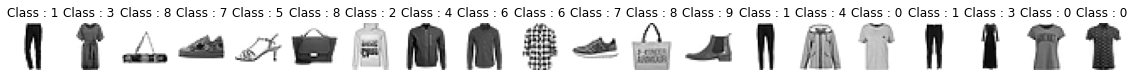

In [6]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
  plt.title(f'Class : {y[idx]}')

In [7]:
X_test = test.values

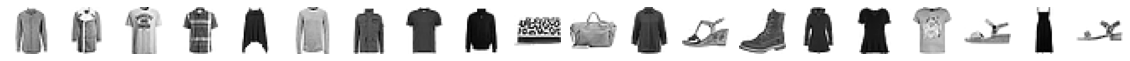

In [8]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

#### Train Test Split

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

## Normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

#### GPU or CPU

In [10]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print(DEVICE)

cpu


#### Hyper - parameter

#### Load DataSet

In [11]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DataSet(Dataset):
    def __init__(self, image, label = None):
        super(DataSet, self).__init__()
        self._image = image
        self._label = label

    def __len__(self):
        return len(self._image)

    def __getitem__(self, idx):
        if self._label is None:
            image = self._image[idx]
            return image

        else:
            image = self._image[idx]
            label = self._label[idx]

            return image, label

In [12]:
BATCH_SIZE = 64
EPOCHS = 100

In [13]:
train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

In [14]:
def train(model, train_loader):
    model.train()
    train_loss = 0
    correct = 0

    for image, label in train_loader:
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        prediction = output.max(1, keepdim = True)[1]
        correct += prediction.eq(label.view_as(prediction)).sum().item()
      
    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, train_accuracy

In [15]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [16]:
def pred(model, test_loader):
    model.eval()
    pred_li = []

    with torch.no_grad():
        for image in test_loader:
            image = image.to(DEVICE)
            output = model(image)
            pred_li.append(output.cpu().numpy().argmax(axis=1))

    return np.concatenate(pred_li)

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.linear2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.linear3 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.linear4 = nn.Sequential(
            nn.Linear(128, 10)
        )

        self._init_weight_()

    def _init_weight_(self):
        for m in self.linear1:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)

        for m in self.linear2:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)

        for m in self.linear3:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.linear4(x)
        return x

- 층을 2개 더 추가하여 진행해봤지만 overfitting 문제로 점수 하락

In [20]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (linear1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (linear2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (linear3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (linear4): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [21]:
result_list = []
for epoch in range(1, EPOCHS + 1):
    train_loss, train_accuracy = train(model, train_loader)
    val_loss, val_accuracy = evaluate(model, val_loader)
    print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
    result = {
        'EPOCH': epoch,
        'Train Loss': train_loss,
        'Train Accuracy': train_accuracy,
        'Val Loss': val_loss,
        'Val Accuracy': val_accuracy}
  
    result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 0.5426, 	Train Accuracy: 81.17 %, 	Val Loss: 0.3683, 	Val Accuracy: 86.51 % 

[EPOCH: 2], 	Train Loss: 0.4003, 	Train Accuracy: 85.32 %, 	Val Loss: 0.3540, 	Val Accuracy: 86.63 % 

[EPOCH: 3], 	Train Loss: 0.3623, 	Train Accuracy: 86.60 %, 	Val Loss: 0.3106, 	Val Accuracy: 88.45 % 

[EPOCH: 4], 	Train Loss: 0.3379, 	Train Accuracy: 87.39 %, 	Val Loss: 0.3029, 	Val Accuracy: 88.85 % 

[EPOCH: 5], 	Train Loss: 0.3197, 	Train Accuracy: 88.27 %, 	Val Loss: 0.3167, 	Val Accuracy: 88.13 % 

[EPOCH: 6], 	Train Loss: 0.3020, 	Train Accuracy: 88.80 %, 	Val Loss: 0.2928, 	Val Accuracy: 89.13 % 

[EPOCH: 7], 	Train Loss: 0.2917, 	Train Accuracy: 89.24 %, 	Val Loss: 0.2938, 	Val Accuracy: 89.39 % 

[EPOCH: 8], 	Train Loss: 0.2760, 	Train Accuracy: 89.71 %, 	Val Loss: 0.3020, 	Val Accuracy: 88.92 % 

[EPOCH: 9], 	Train Loss: 0.2616, 	Train Accuracy: 90.08 %, 	Val Loss: 0.2868, 	Val Accuracy: 89.33 % 

[EPOCH: 10], 	Train Loss: 0.2513, 	Train Accuracy: 90.60 %, 	Val Loss: 0.

[EPOCH: 80], 	Train Loss: 0.0647, 	Train Accuracy: 97.61 %, 	Val Loss: 0.4096, 	Val Accuracy: 90.64 % 

[EPOCH: 81], 	Train Loss: 0.0645, 	Train Accuracy: 97.57 %, 	Val Loss: 0.3847, 	Val Accuracy: 90.82 % 

[EPOCH: 82], 	Train Loss: 0.0602, 	Train Accuracy: 97.75 %, 	Val Loss: 0.4149, 	Val Accuracy: 90.81 % 

[EPOCH: 83], 	Train Loss: 0.0621, 	Train Accuracy: 97.71 %, 	Val Loss: 0.4192, 	Val Accuracy: 90.75 % 

[EPOCH: 84], 	Train Loss: 0.0607, 	Train Accuracy: 97.75 %, 	Val Loss: 0.4008, 	Val Accuracy: 91.17 % 

[EPOCH: 85], 	Train Loss: 0.0640, 	Train Accuracy: 97.72 %, 	Val Loss: 0.4013, 	Val Accuracy: 90.90 % 

[EPOCH: 86], 	Train Loss: 0.0608, 	Train Accuracy: 97.76 %, 	Val Loss: 0.4144, 	Val Accuracy: 90.79 % 

[EPOCH: 87], 	Train Loss: 0.0603, 	Train Accuracy: 97.82 %, 	Val Loss: 0.3897, 	Val Accuracy: 91.02 % 

[EPOCH: 88], 	Train Loss: 0.0587, 	Train Accuracy: 97.82 %, 	Val Loss: 0.3982, 	Val Accuracy: 91.05 % 

[EPOCH: 89], 	Train Loss: 0.0566, 	Train Accuracy: 97.88 %, 	Val

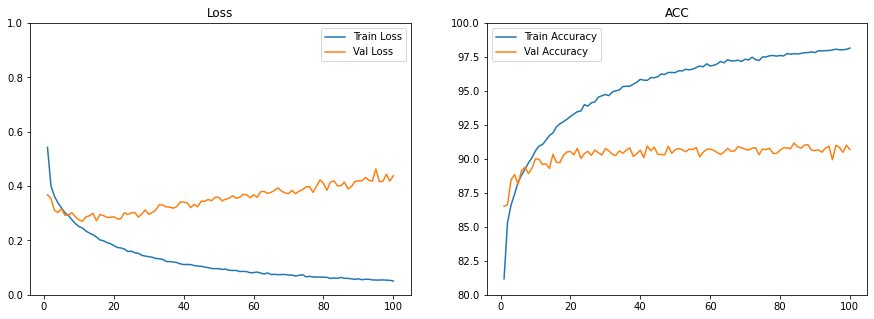

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

In [23]:
pred_label = pred(model, test_loader)

submission['label'] = pred_label

submission.to_csv('BaseLine_Model.csv', index = False)

submission.head()

,id,label
0,0,6
1,1,4
2,2,0
3,3,6
4,4,6
